In [1]:
import numpy as np
from lsst.sims.almanac import Almanac
import matplotlib.pylab as plt
import pandas as pd
import sqlite3
from utils import Constellation, starlink_constellation, grow_hp
import sys

import healpy as hp
%matplotlib inline
from lsst.sims.utils import _raDec2Hpid, hpid2RaDec


In [2]:
def aroundtwi(supersize=False, time=10., mjd_start=59863.0097259146, plot=True, alt_limit=2.):
    sat_tles = starlink_constellation(supersize=supersize)
    nsats = len(sat_tles)
    constellation = Constellation(sat_tles, alt_limit=alt_limit)
    #mjd_start = 59859.375573254 # sunalt = -16.2903238482603 degrees
    #mjd_start = 59863.0097259146 # sunlat = -18.3928422773296
    #mjd_start = 59928.18474603 # Summer around midnight
    step=1./3600/24.
    length = time/60/24.
    #mjd_start += length
    mjds = np.arange(mjd_start, mjd_start+length+step, step)
    nside = 64
    result = np.zeros(hp.nside2npix(nside))
    hpids = np.arange(result.size)
    ra,dec = hpid2RaDec(nside, hpids)
    below = np.where(dec < alt_limit)
    result[below] = np.nan
    for mjd in mjds:
        constellation.update_mjd(mjd)
        above = constellation.above_alt_limit
        hpids = _raDec2Hpid(nside, constellation.azimuth_rad[above], constellation.altitudes_rad[above])
        result[hpids] += 1
    if plot:
        hp.mollview(result, rot=(0,90,0), title='%.1f minutes, %i sats, sunAlt=-18.4 degrees' % (length*60*24, nsats),
                    unit='N Streaks', max=20)

    return result
    
# Note, this is just healpixels that get hit! Need to convolve with 3.5 deg FoV to make sure we don't have any hits.
#plt.savefig('post_twi_example.png')

/Users/yoachim/lsstp3/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-macosx-10.7-x86_64.egg/healpy/pixelfunc.py:304: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/numpy/ma/core.py:2344: RuntimeWarning: invalid value encountered in less_equal
  mabs(xnew - value), atol + rtol * mabs(value))
/Users/yoachim/lsstp3/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-macosx-10.7-x86_64.egg/healpy/projaxes.py:1049: RuntimeWarning: invalid value encountered in less
  result.data[result.data<0]=0.0
/Users/yoachim/lsstp3/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-macosx-10.7-x86_64.egg/healpy/projaxes.py:1050: RuntimeWarning: invalid value encountered in greater
  result.data[result.data>1]=1.0


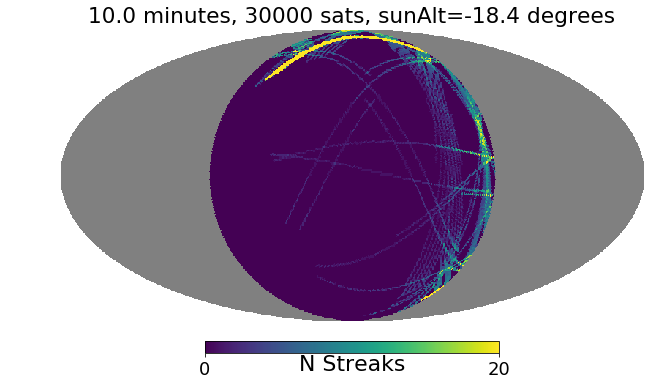

In [3]:
fontsize = 18
plt.rcParams.update({'font.size':fontsize})

regular = aroundtwi()

fontsize = 22

f = plt.gcf().get_children()
HpxAx = f[1]
CbAx = f[2]

coord_text_obj = HpxAx.get_children()[0]
coord_text_obj.set_fontsize(fontsize)

unit_text_obj = CbAx.get_children()[1]
unit_text_obj.set_fontsize(fontsize)


plt.savefig('ten_min_30k.pdf')

In [4]:
fontsize = 18
plt.rcParams.update({'font.size':fontsize})


supers = aroundtwi(supersize=True)
fontsize = 22

f = plt.gcf().get_children()
HpxAx = f[1]
CbAx = f[2]

coord_text_obj = HpxAx.get_children()[0]
coord_text_obj.set_fontsize(fontsize)

unit_text_obj = CbAx.get_children()[1]
unit_text_obj.set_fontsize(fontsize)

plt.savefig('tenmin_example.pdf')

ValueError: line does not conform to tle format

In [ ]:
regular = aroundtwi(time=0.5)
supers = aroundtwi(supersize=True, time=0.5)

In [ ]:
nside = 64
hpmaps = {'Altitude > 30 degrees': regular*0+1,
          '12k satellites, 30s': grow_hp(regular, np.where(regular > 0)[0]),
          '47k satellites, 30s': grow_hp(supers, np.where(supers > 0)[0])}
pixarea = hp.nside2pixarea(nside, degrees=True)
i=1
for key in hpmaps:
    good = np.where(hpmaps[key] >= 0)[0]
    area = pixarea*np.size(good)
    hp.mollview(hpmaps[key], rot=(0,90), title=key, unit='%.0f sq degrees' % area, min=1, max=2)
    i += 1


In [ ]:
mjds = 59863.0097259146 + np.arange(3)/60./24.*.5
maps = []
maps_super = []
for mjd in mjds:
    temp_map = aroundtwi(supersize=False, time=1., mjd_start=mjd, plot=False)
    maps.append(grow_hp(temp_map, np.where(temp_map > 0)[0]))
    temp_map = aroundtwi(supersize=True, time=1., mjd_start=mjd, plot=False)
    maps_super.append(grow_hp(temp_map, np.where(temp_map > 0)[0]))
    

In [ ]:
# Oct 11, 2022. 
plt.figure(figsize=(10,5))
titles = ['0-30s', '30-60s', '60-90s']
for i, temp_map in enumerate(maps):
    if i ==1:
        title = '12k Satellites\n'+titles[i]
    else:
        title = titles[i]
    hp.mollview(temp_map, rot=(0,90), sub=(2,3,i+1), title=title, cbar=False, min=1, max=2)

for i, temp_map in enumerate(maps_super):
    if i ==1:
        title = '47k Satellites\n'+titles[i]
    else:
        title = titles[i]
    hp.mollview(temp_map, rot=(0,90), sub=(2,3,i+1+3), title=title, cbar=False, min=1, max=2)

plt.savefig('sat_steps.pdf')